In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import regex as re

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# TODO

- Choose Best Dataset Variation
    - Apply scaling to the datasets (same dataset with three different encoding methods)
    - Test model performances with their default configurations
    - Choose best performing dataset (if there is a majority in better performances among the models it will be assumed as better)
- Gather Intermediate Report Results
    - Test models with the best performing dataset

---

# Choosing best dataset

Dataset names stands for:
- fe_encoded: First Encounter encoded (assigning new values if the category is never seen before starting from 0)
- ordinal_encoded: Features are ordinally encoded according to the average of the price value in their category
- onehot_encoded: One-Hot encoding method applied version

In [22]:
fe_encoded = pd.read_csv("main_fe_encoded.csv")
ordinal_encoded = pd.read_csv("main_ordinal_encoded.csv")
onehot_encoded = pd.read_csv("main_onehot_encoded.csv")

In [23]:
fe_X = fe_encoded.drop(columns=["price"])
fe_y = fe_encoded["price"]

ordinal_X = ordinal_encoded.drop(columns=["price"])
ordinal_y = ordinal_encoded["price"]

onehot_X = onehot_encoded.drop(columns=["price"])
onehot_y = onehot_encoded["price"]

In [24]:
# in order to see the direct effect of the encoding method, I will set a random_state
fe_X_train, fe_X_test, fe_y_train, fe_y_test = train_test_split(fe_X, fe_y, test_size=0.2, random_state=42)

ordinal_X_train, ordinal_X_test, ordinal_y_train, ordinal_y_test = train_test_split(ordinal_X, ordinal_y, test_size=0.2, random_state=42)

onehot_X_train, onehot_X_test, onehot_y_train, onehot_y_test = train_test_split(onehot_X, onehot_y, test_size=0.2, random_state=42)

## Scaling

In [25]:
scaler = MinMaxScaler()

scaler.fit(fe_X_train)
fe_X_train = scaler.transform(fe_X_train)
fe_X_test = scaler.transform(fe_X_test)

scaler.fit(ordinal_X_train)
ordinal_X_train = scaler.transform(ordinal_X_train)
ordinal_X_test = scaler.transform(ordinal_X_test)

scaler.fit(onehot_X_train)
onehot_X_train = scaler.transform(onehot_X_train)
onehot_X_test = scaler.transform(onehot_X_test)

In [26]:
def pipeline(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse_score = np.sqrt(mean_squared_error(y_test, preds))
    mape_score = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    return rmse_score, mape_score, r2

def dataset_choice_pipeline(model, datasets):
    fe, ordinal, onehot = datasets[0], datasets[1], datasets[2]
    scores = {"fe":[], "ordinal":[], "onehot":[]}
    
    rmse, mape, r2 = pipeline(model, fe[0], fe[1], fe[2], fe[3])
    scores["fe"] += [rmse, mape, r2]

    rmse, mape, r2 = pipeline(model, ordinal[0], ordinal[1], ordinal[2], ordinal[3])
    scores["ordinal"] += [rmse, mape, r2]

    rmse, mape, r2 = pipeline(model, onehot[0], onehot[1], onehot[2], onehot[3])
    scores["onehot"] += [rmse, mape, r2]
    
    return scores

datasets = [[fe_X_train, fe_X_test, fe_y_train, fe_y_test],
            [ordinal_X_train, ordinal_X_test, ordinal_y_train, ordinal_y_test],
            [onehot_X_train, onehot_X_test, onehot_y_train, onehot_y_test]]

### ElasticNet

In [27]:
elastic_scores = dataset_choice_pipeline(ElasticNetCV(random_state=42), datasets)

frame = np.array([elastic_scores["fe"], elastic_scores["ordinal"], elastic_scores["onehot"]])
elastic_scores = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
elastic_scores

,rmse,mape,r2
fe,390.848640,0.297442,0.138592
ordinal,364.774032,0.273000,0.249692
onehot,354.457186,0.261303,0.291534


### SVR

In [ ]:
svr_scores = dataset_choice_pipeline(SVR(verbose=True), datasets)

frame = np.array([svr_scores["fe"], svr_scores["ordinal"], svr_scores["onehot"]])
svr_scores = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
svr_scores

[LibSVM]

- terminated the code because it took so long

### KNN

In [10]:
knn_scores = dataset_choice_pipeline(KNeighborsRegressor(), datasets)

frame = np.array([knn_scores["fe"], knn_scores["ordinal"], knn_scores["onehot"]])
knn_scores = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
knn_scores

,rmse,mape,r2
fe,237.595526,0.120430,0.681677
ordinal,211.442907,0.105563,0.747897
onehot,193.793512,0.095469,0.788227


### Decision Tree

In [24]:
tree_scores = dataset_choice_pipeline(DecisionTreeRegressor(random_state=42), datasets)

frame = np.array([tree_scores["fe"], tree_scores["ordinal"], tree_scores["onehot"]])
tree_scores = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
tree_scores

,rmse,mape,r2
fe,175.073685,0.070220,0.827164
ordinal,171.691635,0.069206,0.833778
onehot,173.759803,0.069728,0.829749


### RandomForest

In [30]:
rf_scores = dataset_choice_pipeline(RandomForestRegressor(random_state=42, verbose=2), datasets)

frame = np.array([rf_scores["fe"], rf_scores["ordinal"], rf_scores["onehot"]])
rf_results = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
rf_results

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   45.9s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   48.7s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


,rmse,mape,r2
fe,129.149969,0.059247,0.905945
ordinal,128.953169,0.058665,0.906232
onehot,129.752198,0.058917,0.905066


In [31]:
rf_results

,rmse,mape,r2
fe,129.149969,0.059247,0.905945
ordinal,128.953169,0.058665,0.906232
onehot,129.752198,0.058917,0.905066


### AdaBoost

In [29]:
ada_scores = dataset_choice_pipeline(AdaBoostRegressor(random_state=42), datasets)

frame = np.array([ada_scores["fe"], ada_scores["ordinal"], ada_scores["onehot"]])
ada_results = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
ada_results

,rmse,mape,r2
fe,329.426384,0.292852,0.388061
ordinal,338.941513,0.300530,0.352200
onehot,332.747833,0.295305,0.375659


AdaBoost resulted best in also support fe encoding

### XGBoost

In [25]:
xgb_scores = dataset_choice_pipeline(XGBRegressor(random_state=42, verbosity=2), datasets)

frame = np.array([xgb_scores["fe"], xgb_scores["ordinal"], xgb_scores["onehot"]])
xgb_scores = pd.DataFrame(frame, index=["fe", "ordinal", "onehot"], columns=["rmse", "mape", "r2"])
xgb_scores

C:\Users\erdem\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\erdem\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
C:\Users\erdem\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


,rmse,mape,r2
fe,160.793286,0.100921,0.854210
ordinal,159.550516,0.100003,0.856455
onehot,162.484492,0.102256,0.851127


XGBoost results also support ordinal encoding having the best result

### Conclusion of this part
- ElasticNet gives best results in one-hot encoding, AdaBoost performs best in fe encoding and the rest of the models perform best in ordinal encoding. I didn't experimented with svr because it took so long to train
- Due to the majority being in the ordinal encoding, I will carry on with that dataset

# Gathering Results for the Intermediate Report

In [2]:
def pipeline(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse_score = np.sqrt(mean_squared_error(y_test, preds))
    mape_score = mean_absolute_percentage_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    return rmse_score, mape_score, r2

- I decided to add ElasticNet to the models list. This was not stated in the project proposal, but I wanted to add more models.

First, lets get rid of the redundant dataset names

In [3]:
data = pd.read_csv("main_ordinal_encoded.csv")
X = data.drop(columns=["price"])
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f"Shape of the whole dataset: {X.shape} {y.shape}")
print(f"Shape of the train set: {X_train.shape} {y_train.shape}")
print(f"Shape of the test set: {X_test.shape} {y_test.shape}")

Shape of the whole dataset: (190551, 19) (190551,)
Shape of the train set: (152440, 19) (152440,)
Shape of the test set: (38111, 19) (38111,)


In [37]:
model_scores = {}

## ElasticNetCV

In [18]:
elastic = ElasticNetCV(l1_ratio=1, eps=0.0001)

rmse, mape, r2 = pipeline(elastic, X_train, X_test, y_train, y_test)

model_scores["ElasticNet"] = [rmse, mape, r2]
model_scores["ElasticNet"]

[270.7406674733359, 0.18565555658414173, 0.5866685158435163]

## SVR

In [19]:
svreg = SVR(verbose=True)

rmse, mape, r2 = pipeline(svreg, X_train, X_test, y_train, y_test)

model_scores["SVR"] = [rmse, mape, r2]
model_scores["SVR"]

[LibSVM]

[274.63620093736716, 0.17241549107349216, 0.5746885618500026]

## KNN

In [30]:
knn = KNeighborsRegressor(n_neighbors=50)

rmse, mape, r2 = pipeline(knn, X_train, X_test, y_train, y_test)

model_scores["KNN"] = [rmse, mape, r2]
model_scores["KNN"]

[246.9849063609118, 0.1495097516709746, 0.6560206874309943]

## Decision Tree

In [18]:
tree = DecisionTreeRegressor()

rmse, mape, r2 = pipeline(tree, X_train, X_test, y_train, y_test)

model_scores["DecisionTree"] = [rmse, mape, r2]
model_scores["DecisionTree"]

[172.1892392841659, 0.06949420897645131, 0.8328126124205872]

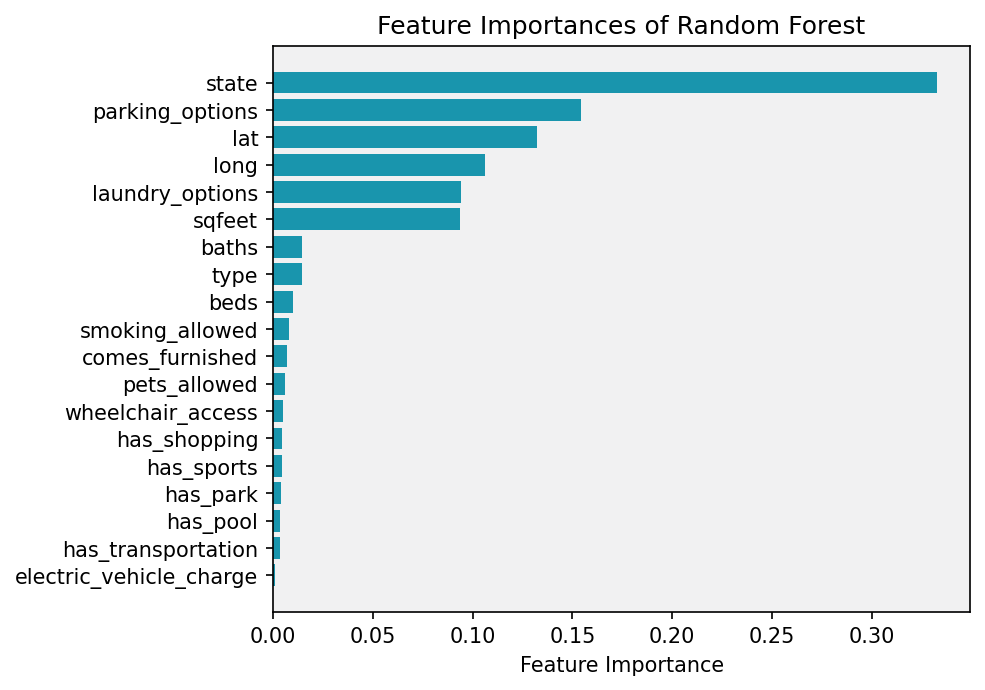

In [19]:
importances = pd.Series({i:j for i,j in zip(X.columns, tree.feature_importances_)}).sort_values()

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ax.set_facecolor("#f1f1f2")

plt.barh(importances.index, importances.values, color="#1995ad")
plt.title("Feature Importances of Random Forest")
plt.xlabel("Feature Importance");

## RandomForest

In [20]:
rf = RandomForestRegressor(n_estimators=150, verbose=2)

rmse, mape, r2 = pipeline(rf, X_train, X_test, y_train, y_test)

model_scores["RandomForest"] = [rmse, mape, r2]
model_scores["RandomForest"]

building tree 1 of 150
building tree 2 of 150
building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150
building tree 39 of 150
building tree 40 of 150


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   46.6s


building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80 of 150
building tree 81 of 150
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


[128.92331831114063, 0.05858553086689827, 0.9062752162155652]

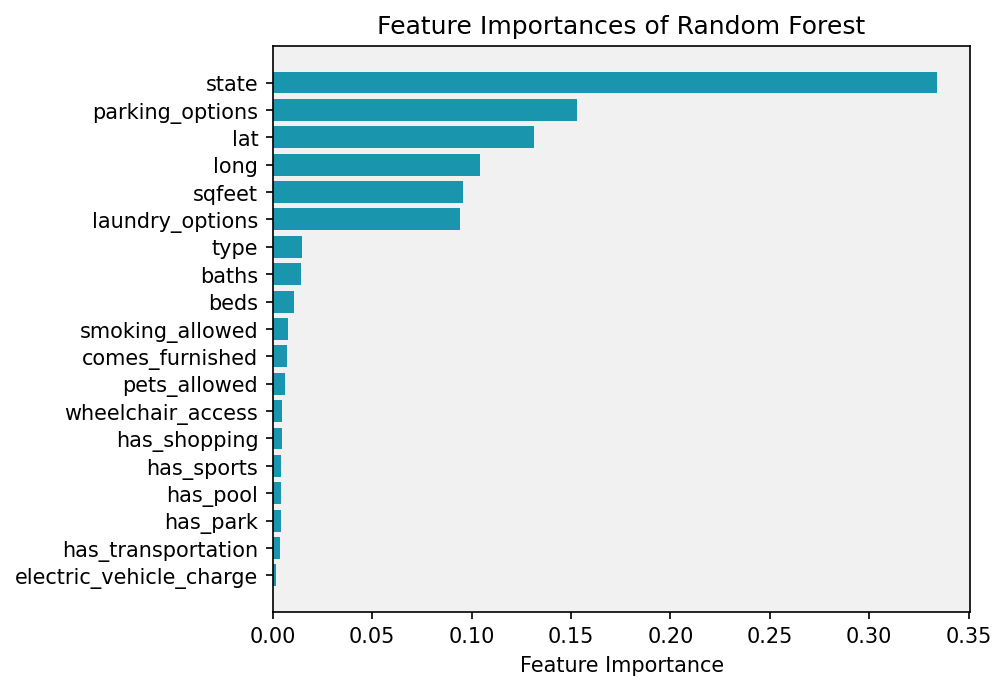

In [21]:
importances = pd.Series({i:j for i,j in zip(X.columns, rf.feature_importances_)}).sort_values()

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ax.set_facecolor("#f1f1f2")

plt.barh(importances.index, importances.values, color="#1995ad")
plt.title("Feature Importances of Random Forest")
plt.xlabel("Feature Importance");

## AdaBoost

In [22]:
ada = AdaBoostRegressor(learning_rate=0.1)

rmse, mape, r2 = pipeline(ada, X_train, X_test, y_train, y_test)

model_scores["AdaBoost"] = [rmse, mape, r2]
model_scores["AdaBoost"]

[279.00400166863614, 0.21182845569000147, 0.5610527207242899]

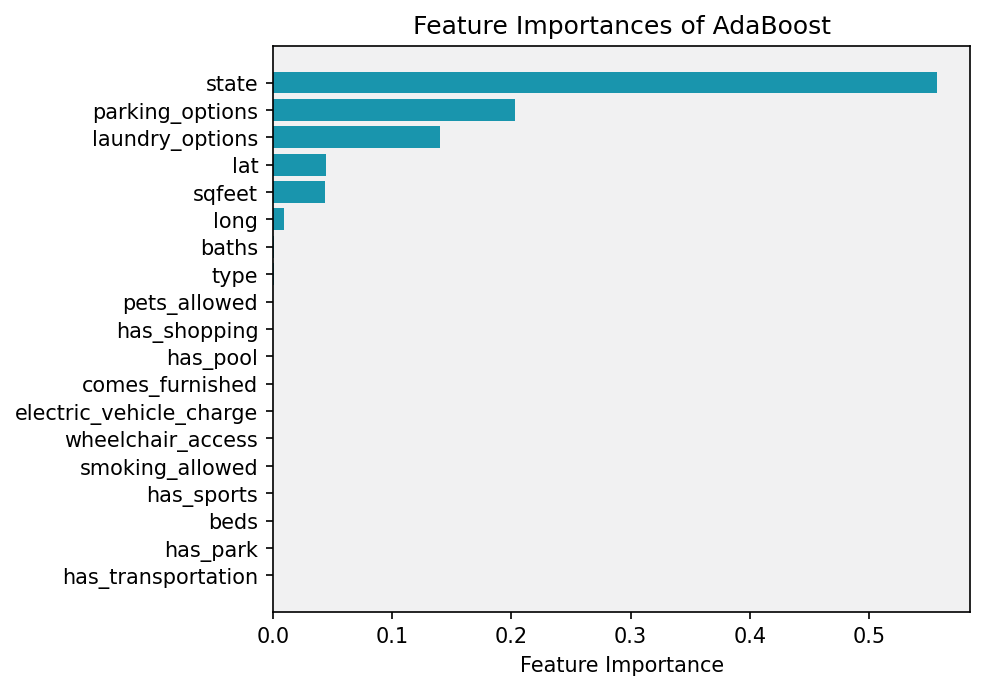

In [23]:
importances = pd.Series({i:j for i,j in zip(X.columns, ada.feature_importances_)}).sort_values()

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ax.set_facecolor("#f1f1f2")

plt.barh(importances.index, importances.values, color="#1995ad")
plt.title("Feature Importances of AdaBoost")
plt.xlabel("Feature Importance");

## XGBoost

In [24]:
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.2)

rmse, mape, r2 = pipeline(xgb, X_train, X_test, y_train, y_test)

model_scores["XGBoost"] = [rmse, mape, r2]
model_scores["XGBoost"]

C:\Users\erdem\anaconda3\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[132.84085542331854, 0.07397301059813294, 0.9004927271123584]

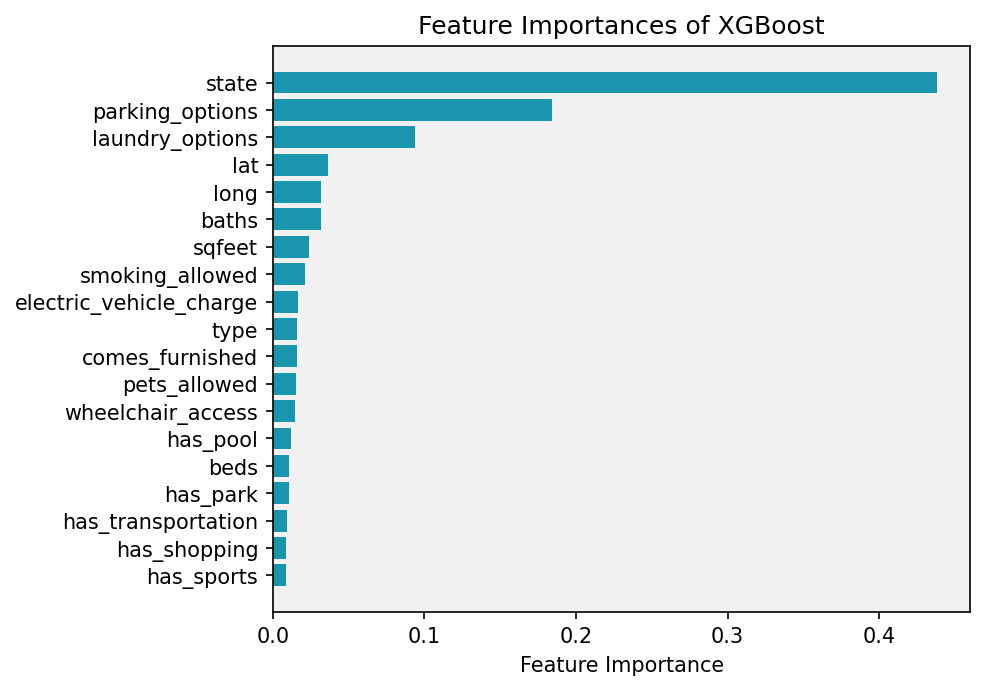

In [25]:
importances = pd.Series({i:j for i,j in zip(X.columns, xgb.feature_importances_)}).sort_values()

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ax.set_facecolor("#f1f1f2")

plt.barh(importances.index, importances.values, color="#1995ad")
plt.title("Feature Importances of XGBoost")
plt.xlabel("Feature Importance");

## Results

In [45]:
pd.DataFrame(model_scores, index=["RMSE", "MAPE", "R2"])

,ElasticNet,SVR,KNN,DecisionTree,RandomForest,AdaBoost,XGBoost
RMSE,270.740667,274.636201,246.984906,172.189239,128.923318,279.004002,132.840855
MAPE,0.185656,0.172415,0.149510,0.069494,0.058586,0.211828,0.073973
R2,0.586669,0.574689,0.656021,0.832813,0.906275,0.561053,0.900493


In [46]:
results = pd.DataFrame(model_scores, index=["RMSE", "MAPE", "R2"]).T
results

,RMSE,MAPE,R2
ElasticNet,270.740667,0.185656,0.586669
SVR,274.636201,0.172415,0.574689
KNN,246.984906,0.149510,0.656021
DecisionTree,172.189239,0.069494,0.832813
RandomForest,128.923318,0.058586,0.906275
AdaBoost,279.004002,0.211828,0.561053
XGBoost,132.840855,0.073973,0.900493


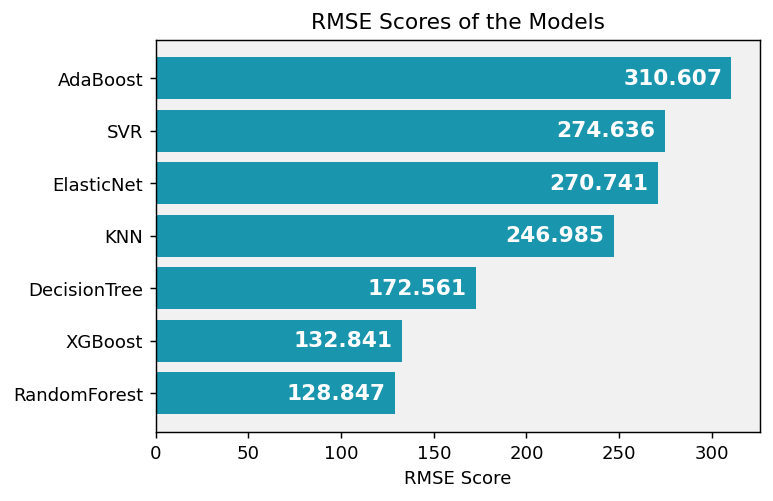

In [41]:
fig, ax = plt.subplots(figsize=(6,4), dpi=130)
ax.set_facecolor("#f1f1f2")

viz_result = results["RMSE"].sort_values()
plt.barh(viz_result.index, viz_result.values, color="#1995ad")
plt.title("RMSE Scores of the Models")
plt.xlabel("RMSE Score")

for i, value in enumerate(viz_result):
    plt.text(value-5, i, f"{value:.3f}", va="center", ha="right", weight="bold", c="white", fontsize="large")

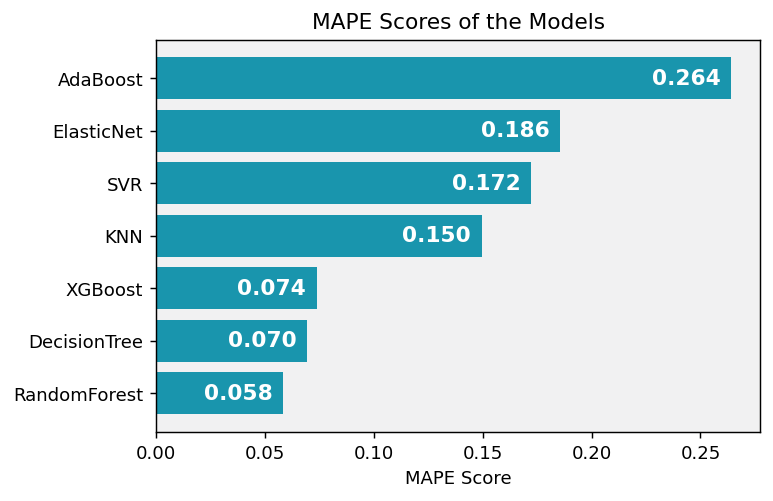

In [42]:
fig, ax = plt.subplots(figsize=(6,4), dpi=130)
ax.set_facecolor("#f1f1f2")

viz_result = results["MAPE"].sort_values()
plt.barh(viz_result.index, viz_result.values, color="#1995ad")
plt.title("MAPE Scores of the Models")
plt.xlabel("MAPE Score")

for i, value in enumerate(viz_result):
    plt.text(value-.005, i, f"{value:.3f}", va="center", ha="right", weight="bold", c="white", fontsize="large")

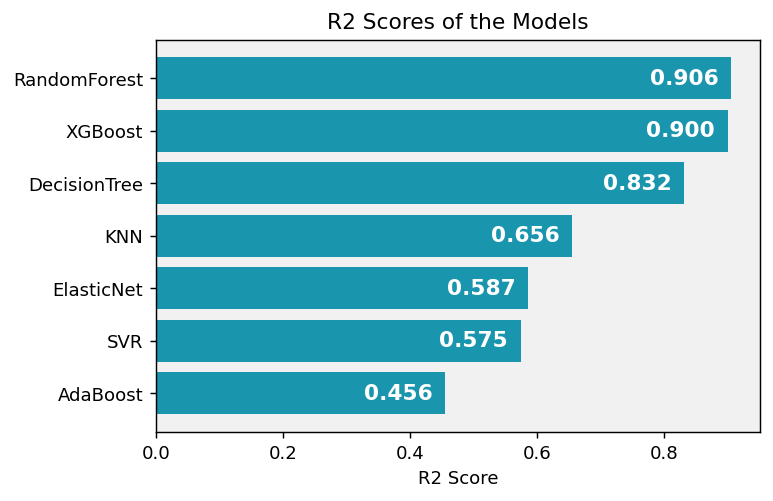

In [43]:
fig, ax = plt.subplots(figsize=(6,4), dpi=130)
ax.set_facecolor("#f1f1f2")

viz_result = results["R2"].sort_values()
plt.barh(viz_result.index, viz_result.values, color="#1995ad")
plt.title("R2 Scores of the Models")
plt.xlabel("R2 Score")

for i, value in enumerate(viz_result):
    plt.text(value-.02, i, f"{value:.3f}", va="center", ha="right", weight="bold", c="white", fontsize="large")